In [57]:
%matplotlib inline
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
import sklearn
import seaborn as sns
import geopandas as gpd
import scipy
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import skew
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn import datasets, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, Imputer
from collections import defaultdict

In [58]:
print("Python:", sys.version[:5])
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Seaborn:", scipy.__version__)
print("GeoPandas:", gpd.__version__)
print("SciPy:", scipy.__version__)

Python: 3.7.0
Pandas: 0.23.4
Numpy: 1.15.3
Matplotlib: 3.0.1
Scikit-learn: 0.20.0
Seaborn: 1.1.0
GeoPandas: 0.3.0
SciPy: 1.1.0


In [59]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
prices_folder = Path("data/")
cols_2excl = ['CLASS', 'STNO', 'STnu', 'FLATPOSN', 'YEAR OF SALE (BUSINESS)', 'RPI', 'DEFLATOR', 'OMIT OR USE']
new_cols = ['street', 'postcode', 'sale_month', 'sale_year', 'sale_date', 'sale_quarter', 'nominal_price',
            'july_2013_price', 'buyer_origin', 'build', 'local_housing_forum']

fp = "/home/david/Desktop/Personal/University/CS982/Assignment/alternative_data/2011_Census_Glasgow_City_(shp)/DZ_2011_EoR_Glasgow_City.shp"
map_df = gpd.read_file(fp)

In [60]:
map_df.head()

,GSS_CODEDZ,DZ_Name,GSS_CODECA,CA_Name,GSS_CODEIZ,geometry
0,S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,..."
1,S01003026,None,S12000046,Glasgow_City,S02000584,"POLYGON ((258523 659616, 258532 659448, 258583..."
2,S01003027,None,S12000046,Glasgow_City,S02000587,"POLYGON ((254367.8425000003 658647.1636999995,..."
3,S01003028,None,S12000046,Glasgow_City,S02000585,"POLYGON ((260169 658643, 260179 658592, 260209..."
4,S01003029,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259204 658200, 259174 658180, 259164..."


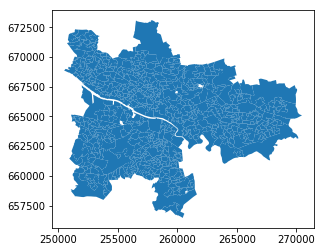

In [61]:
map_df.plot()

In [62]:
def concatenate(folder):
    file_list = folder.glob("*.csv")  # Find .csv files
    df_list = []
    for file_name in file_list:
        single_df = pd.read_csv(file_name, low_memory=False)
        clean_df = single_df[:-1]  # Remove last row of each CSV file as it's not relevant
        df_list.append(clean_df)
    df = pd.concat(df_list, axis=0, sort=False)  # Concatenate CSV files
    df.drop(columns=cols_2excl, inplace=True)  # Drop useless columns
    df.columns = new_cols  # Rename columns with code-friendly terms
    # Regular Expression to convert date formats from YYYY-MM-DD to YYYY-MM as DD was always 01 anyway
    df.sale_date = df.sale_date.str.replace(r'-\d{2}$', r'', regex=True)
    # Regular Expression to convert date formats from DD/MM/YYYY to YYYY-MM
    df.sale_date = df.sale_date.str.replace(r'\d{2}\/(\d{2})\/(\d{4})$', r'\2-\1', regex=True)
    return df

In [63]:
def from_xls():
    xls = pd.ExcelFile('data/datazones.xls')
    dz_df = pd.read_excel(xls, 'Sheet1')
    dz_df = dz_df[['Postcode', 'DataZone']]
    dz_df.columns = ['postcode', 'datazone']
    return dz_df

In [64]:
def merge_df(simd_df, left_df, column, year, first):
    new_col = ''.join(column + '_' + str(year))
    right_df = simd_df[['Datazone', new_col]]
    right_df.columns = ['datazone', column]
    right_df['sale_year'] = year
    merged_df = pd.merge(left_df, right_df, how='left', on=['datazone', 'sale_year'])
    dupl_col_x = ''.join(column + '_x')
    dupl_col_y = ''.join(column + '_y')
    if not first:
        merged_df[column] = merged_df[dupl_col_x].fillna(merged_df[dupl_col_y])
        merged_df.drop(columns=[dupl_col_x, dupl_col_y], inplace=True)
    return merged_df

In [65]:
def create_pdf_fig(filename):
    pwd = os.path.abspath(os.path.dirname(sys.argv[0]))
    graph_path = os.path.join(pwd, '{}.pdf'.format(filename))
    pdf = PdfPages(graph_path)
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    plt.show()
    pdf.close()
    pdf = None

In [66]:
dataframe = concatenate(prices_folder)
datazone_df = from_xls()

merged = pd.merge(dataframe, datazone_df, on='postcode')

In [67]:
overall_simd_df = pd.read_csv('data/simd/simd-overall-2004-2012-glasgow-v2.csv')
employ_simd_df = pd.read_csv('data/simd/simd-employment-2004-2012-glasgow-v2.csv')
income_simd_df = pd.read_csv('data/simd/simd-income-2004-2012-glasgow-v2.csv')
health_simd_df = pd.read_csv('data/simd/simd-health-2004-2012-glasgow-v2.csv')
edu_simd_df = pd.read_csv('data/simd/simd-education-2004-2012-glasgow-v2.csv')
geo_simd_df = pd.read_csv('data/simd/simd-geographic-access-2004-2012-glasgow-v2.csv')
housing_simd_df = pd.read_csv('data/simd/simd-housing-2004-2012-glasgow-v2.csv')
crime_simd_df = pd.read_csv('data/simd/simd-crime-2006-2012-glasgow-v2.csv')

overall_col = 'overall_deprivation_rank'
overall_04 = merge_df(overall_simd_df, merged, overall_col, 2004, True)
overall_06 = merge_df(overall_simd_df, overall_04, overall_col, 2006, False)
overall_09 = merge_df(overall_simd_df, overall_06, overall_col, 2009, False)
overall_12 = merge_df(overall_simd_df, overall_09, overall_col, 2012, False)

empl_col = 'employment_deprivation_rank'
empl_04 = merge_df(employ_simd_df, overall_12, empl_col, 2004, True)
empl_06 = merge_df(employ_simd_df, empl_04, empl_col, 2006, False)
empl_09 = merge_df(employ_simd_df, empl_06, empl_col, 2009, False)
empl_12 = merge_df(employ_simd_df, empl_09, empl_col, 2012, False)

income_col = 'income_deprivation_rank'
income_04 = merge_df(income_simd_df, empl_12, income_col, 2004, True)
income_06 = merge_df(income_simd_df, income_04, income_col, 2006, False)
income_09 = merge_df(income_simd_df, income_06, income_col, 2009, False)
income_12 = merge_df(income_simd_df, income_09, income_col, 2012, False)

health_col = 'health_deprivation_rank'
health_04 = merge_df(health_simd_df, income_12, health_col, 2004, True)
health_06 = merge_df(health_simd_df, health_04, health_col, 2006, False)
health_09 = merge_df(health_simd_df, health_06, health_col, 2009, False)
health_12 = merge_df(health_simd_df, health_09, health_col, 2012, False)

edu_col = 'education_deprivation_rank'
edu_04 = merge_df(edu_simd_df, health_12, edu_col, 2004, True)
edu_06 = merge_df(edu_simd_df, edu_04, edu_col, 2006, False)
edu_09 = merge_df(edu_simd_df, edu_06, edu_col, 2009, False)
edu_12 = merge_df(edu_simd_df, edu_09, edu_col, 2012, False)

geo_col = 'geographic_access_deprivation_rank'
geo_04 = merge_df(geo_simd_df, edu_12, geo_col, 2004, True)
geo_06 = merge_df(geo_simd_df, geo_04, geo_col, 2006, False)
geo_09 = merge_df(geo_simd_df, geo_06, geo_col, 2009, False)
geo_12 = merge_df(geo_simd_df, geo_09, geo_col, 2012, False)

housing_col = 'housing_deprivation_rank'
housing_04 = merge_df(housing_simd_df, geo_12, housing_col, 2004, True)
housing_06 = merge_df(housing_simd_df, housing_04, housing_col, 2006, False)
housing_09 = merge_df(housing_simd_df, housing_06, housing_col, 2009, False)
housing_12 = merge_df(housing_simd_df, housing_09, housing_col, 2012, False)

crime_col = 'crime_deprivation_rank'
crime_06 = merge_df(crime_simd_df, housing_12, crime_col, 2006, True)
crime_09 = merge_df(crime_simd_df, crime_06, crime_col, 2009, False)
crime_12 = merge_df(crime_simd_df, crime_09, crime_col, 2012, False)

df = crime_12

In [68]:
df = df.sort_values(by=['sale_date', 'july_2013_price'], ascending=False)
df = df[['street', 'postcode', 'datazone', 'local_housing_forum', overall_col, empl_col, income_col,
                     health_col, edu_col, geo_col, housing_col, crime_col, 'sale_date', 'sale_quarter',
                     'sale_year', 'sale_month', 'nominal_price', 'july_2013_price', 'build', 'buyer_origin']]

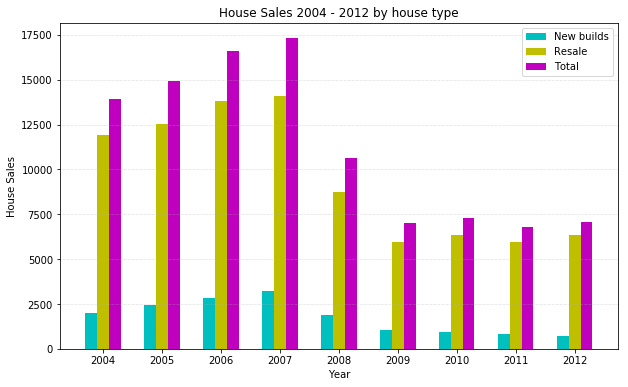

In [205]:
# fig = plt.figure(figsize=(10,6))
# years = {}
# years = defaultdict(lambda: 0, years)

# for row in df.itertuples():
#     try:
#         years[int(row.sale_year)] += 1
#     except:
#         print()

# (labels, values) = zip(*years.items())
# labels, values  = zip(*sorted(zip(labels, values), ))

# y_pos = np.arange(len(labels))
# plt.bar(y_pos, values, align='center', alpha=0.7, color='g')
# plt.xticks(y_pos, labels)
# plt.grid(linestyle=':', linewidth=0.5, axis='y')
# plt.title("House Sales 2004 - 2012")
# plt.xlabel("Year")
# plt.ylabel("House Sales")
# fig.savefig('sales_per_year.pdf', bbox_inches="tight")

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
years = ['2004','2005','2006','2007','2008','2009','2010','2011','2012']

def inc(string):
    l = []
    year = 2004
    for i in range(0,9):
        if string == 't':
            n = len(df[df.sale_year.isin([str(year)])])
        else:
            n = len(df[df.sale_year.isin([str(year)]) & df.build.isin([string])])
        l.append(n)
        year+=1
    return l

# print(len(df[df.sale_year.isin([str(2012)])]))
                   
n = inc('NEW')
r = inc('RESALE')
t = inc('t')

_X = np.arange(len(years))
# plt.yticks(np.arange(0, 1, 0.1))

plt.bar(_X - 0.2, n, 0.2, color='c')
plt.bar(_X, r, 0.2, color='y')
plt.bar(_X+0.2, t, 0.2, color='m')
plt.xticks(_X, years) # set labels manually
plt.grid(linestyle=':', linewidth=0.5, axis='y')
plt.title("House Sales 2004 - 2012 by house type")
plt.xlabel("Year")
plt.ylabel("House Sales")
ax.legend(('New builds', 'Resale','Total'))
fig.savefig('sales_per_year.pdf', bbox_inches="tight")

In [189]:
# len(df[(df['build'] == 'NEW') & (df['sale_year'] == 'RESALE')])
# df[df['build'] == 'NEW'].value_counts()
print(len(df[df['sale_year'].isin(['2012'])]))
len(df[df.sale_year.isin(['2012']) & 
           df.build.isin(['NEW'])])

# dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
# fig = plt.figure(figsize=(30,6))
# quarters = {}
# quarters = defaultdict(lambda: 0, quarters)

# for row in df.itertuples():
#     try:
#         quarters[row.sale_quarter] += 1
#     except:
#         print()

# (labels, values) = zip(*quarters.items())
# labels, values  = zip(*sorted(zip(labels, values), ))

# y_pos = np.arange(len(labels))
# plt.bar(y_pos, values, 0.1, align='center', alpha=0.5, color='g')
# plt.xticks(y_pos, labels)
# plt.grid(linestyle=':', linewidth=0.5, axis='y')
# plt.xlabel("Quarter")
# plt.ylabel("House Sales")
# plt.autoscale(enable=True, axis='x')
# fig.savefig('sales_per_quarter.pdf', bbox_inches="tight")

7055


738

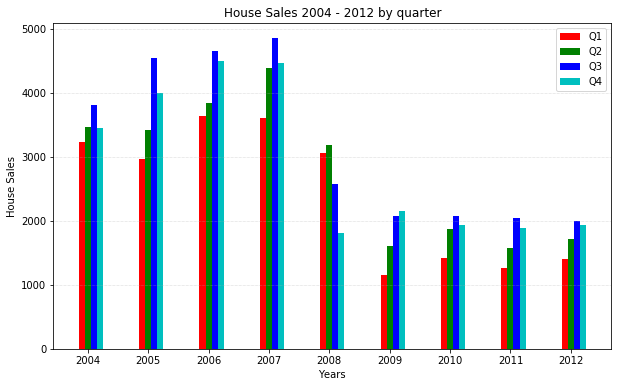

In [148]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
years = ['2004','2005','2006','2007','2008','2009','2010','2011','2012']

def inc(quarter):
    l = []
    year = 2004
    for i in range(0,9):
        string = str(year) + ' Q' + str(quarter)
        amount = len(df[df['sale_quarter'] == string])
        l.append(amount)
        year+=1
    return l
        
q1 = inc(1)
q2 = inc(2)
q3 = inc(3)
q4 = inc(4)

_X = np.arange(len(years))
# plt.yticks(np.arange(0, 1, 0.1))

plt.bar(_X - 0.1, q1, 0.1, color='r')
plt.bar(_X, q2, 0.1, color='g')
plt.bar(_X + 0.1, q3, 0.1, color='b')
plt.bar(_X + 0.2, q4, 0.1, color='c')
plt.xticks(_X, years) # set labels manually
plt.grid(linestyle=':', linewidth=0.5, axis='y')
plt.title("House Sales 2004 - 2012 by quarter")
plt.xlabel("Years")
plt.ylabel("House Sales")
ax.legend(('Q1', 'Q2',
           'Q3', 'Q4'))
fig.savefig('sales_per_quarter.pdf', bbox_inches="tight")

In [104]:
len(df[df['sale_quarter'] == '2004 Q1'])

# df.pivot("sale_year", "sale_month", "sale_quarter").plot(kind='bar')

# plt.show()


3231

In [14]:
# Remove some columns
df.drop(columns=['nominal_price', 'street', 'postcode', 'sale_date',
                 'sale_quarter', 'local_housing_forum'], inplace=True)

In [15]:
df = df.rename(index=str, columns={"sale_month": "month", "sale_year": "year", "sale_quarter":"quarter", "sale_date":"date",
                                      "crime_deprivation_rank":"crime", "housing_deprivation_rank":"housing",
                                      "geographic_access_deprivation_rank":"geographic_access", "education_deprivation_rank":"education",
                                      "health_deprivation_rank":"health", "income_deprivation_rank":"income",
                                      "employment_deprivation_rank":"employment", "overall_deprivation_rank":"overall",
                                      "july_2013_price":"price"})

In [16]:
# Drop NaN rows, keeps 2006, 2009, 2012 only
df = df[pd.notnull(df['overall'])]

df = df.fillna(df.median())

In [17]:
df_for_map = df[['datazone','price','overall','employment','income','health','education','geographic_access','housing','crime','year','month','build']]
df_for_map.head()

,datazone,price,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build
82784,S01003453,925751.62,4924.0,4904.0,4597.0,5883.0,2905.0,5991.0,519.0,2642.0,2012,12.0,RESALE
61074,S01003597,740601.30,5841.0,5409.0,5990.0,4259.0,5792.0,3694.0,4794.0,3535.0,2012,12.0,RESALE
76796,S01003545,682931.52,6356.0,5687.0,5949.0,6467.0,6000.0,5921.0,1442.0,4281.0,2012,12.0,RESALE
46540,S01003257,627285.25,3387.0,4364.0,2582.0,4200.0,2915.0,1962.0,1019.0,3990.0,2012,12.0,RESALE
23603,S01003025,624502.94,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012,12.0,RESALE


In [18]:
merged_map = map_df.set_index('GSS_CODEDZ').join(df_for_map.set_index('datazone'))
merged_map.head()

,DZ_Name,GSS_CODECA,CA_Name,GSS_CODEIZ,geometry,price,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",624502.94,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,12.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",152504.07,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,11.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",254173.45,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,10.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",454375.52,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,6.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",489103.09,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,4.0,RESALE


In [19]:
# variable = 'price'
# vmin, vmax = 0, 1

# # create figure and axes for Matplotlib
# fig, ax = plt.subplots(1, figsize=(10, 6))

# merged_map.plot(column=variable, cmap='YlGn', ax=ax,
#             linewidth=0.1, edgecolor='0.5', scheme='equal_interval',
#             k=15)

# ax.axis('off')
# ax.set_title('Glasgow Overall SIMD', \
#               fontdict={'fontsize': '25',
#                         'fontweight' : '3'})

# # create an annotation for the  data source
# ax.annotate('Source: Glasgow Open Data, 2014',
#            xy=(0.1, .08), xycoords='figure fraction',
#            horizontalalignment='left', verticalalignment='top',
#            fontsize=10, color='#555555')

# # Create colorbar as a legend
# sm = plt.cm.ScalarMappable(cmap='YlGn')
# sm._A = []
# cbar = fig.colorbar(sm)

# # this will save the figure as a high-res png. you can also save as svg
# # fig.savefig('testmap.png', dpi=800)

In [20]:
df.to_csv(path_or_buf='dataframe.csv', index=False)

In [21]:
df.year = df.year.astype(str)
df.month = pd.to_numeric(df.month, downcast='integer')
df.month = df.month.astype(str)

In [22]:
print(df.dtypes)

datazone              object
overall              float64
employment           float64
income               float64
health               float64
education            float64
geographic_access    float64
housing              float64
crime                float64
year                  object
month                 object
price                float64
build                 object
buyer_origin          object
dtype: object


In [23]:
df.head()

,datazone,overall,employment,income,health,education,geographic_access,housing,crime,year,month,price,build,buyer_origin
82784,S01003453,4924.0,4904.0,4597.0,5883.0,2905.0,5991.0,519.0,2642.0,2012,12,925751.62,RESALE,GLASGOW
61074,S01003597,5841.0,5409.0,5990.0,4259.0,5792.0,3694.0,4794.0,3535.0,2012,12,740601.30,RESALE,GLASGOW
76796,S01003545,6356.0,5687.0,5949.0,6467.0,6000.0,5921.0,1442.0,4281.0,2012,12,682931.52,RESALE,GLASGOW
46540,S01003257,3387.0,4364.0,2582.0,4200.0,2915.0,1962.0,1019.0,3990.0,2012,12,627285.25,RESALE,GLASGOW
23603,S01003025,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012,12,624502.94,RESALE,CLARKSTON


In [24]:
# df.local_housing_forum = df.local_housing_forum.str.replace(' ', '_')
# df = pd.get_dummies(df, columns=['local_housing_forum'])
# = pd.get_dummies(df, columns=['build'], drop_first=True)
# df = df.rename(index=str, columns={"build_RESALE": "resale"
#                                       ,"local_housing_forum_Baillieston_Shettleston": "Baillieston_Shettleston",
#                                       "local_housing_forum_Drumchapel_Anniesland_and_Garscadden_Scotstounhill": "Drumchapel_Anniesland_Garscadden_Scotstounhill",
#                                       "local_housing_forum_East_Centre_and_Calton": "East_Centre_Calton",
#                                       "local_housing_forum_Central_and_West": "Central_West",
#                                       "local_housing_forum_Govan_and_Craigton": "Govan_Craigton",
#                                       "local_housing_forum_Greater_Pollok_and_Newlands_Auldburn": "Greater_Pollok_Newlands_Auldburn",
#                                       "local_housing_forum_Langside_and_Linn": "Langside_Linn",
#                                       "local_housing_forum_Maryhill_Kelvin_and_Canal": "Maryhill_Kelvin_Canal",
#                                       "local_housing_forum_Pollokshields_and_Southside_Central": "Pollokshields_Southside_Central",
#                                       "local_housing_forum_Springburn": "Springburn"
#                                   })
# df.datazone = df.datazone.str.replace(r'S\d{5}', r'', regex=True)
# df.datazone = df.datazone.apply(pd.to_numeric)
# df = pd.get_dummies(df, columns=['buyer_origin'])
# df = pd.get_dummies(df, columns=['datazone'])
# le = LabelEncoder()
# df['buyer_origin'] = le.fit_transform(df['buyer_origin'].astype(str))
# print(df.dtypes)

In [25]:
total_dz = 6505
df.overall = df.overall/total_dz
df.employment = df.employment/total_dz
df.income = df.income/total_dz
df.health = df.health/total_dz
df.education = df.education/total_dz
df.geographic_access = df.geographic_access/total_dz
df.housing = df.housing/total_dz
df.crime = df.crime/total_dz

In [26]:
# fig = plt.figure(figsize=(10,6))
# ax = plt.subplot(111)
# x = ['Ward - Euclidean',
#      'Average - Euclidean',
#      'Average - Manhattan',
#      'Complete - Euclidean',
#      'Complete - Manhattan']

# y = [0.4585054410838514, 0.411178230729844, 0.38054918724238823,
#      0.41757725658002337, 0.3939523655501585]
# z = [0.8871998368269876, 0.8714664029864378, 0.8705347573408821,
#      0.8804779252681949, 0.8787845930927598]
# k = [0.8590934815745167, 0.8570671637777433, 0.8569801407406784,
#      0.8581845355703639, 0.8580289478960755]

# _X = np.arange(len(x))
# plt.yticks(np.arange(0, 1, 0.1))

# plt.bar(_X - 0.1, y, 0.1, color='r')
# plt.bar(_X, z, 0.1, color='g')
# plt.bar(_X + 0.1, k, 0.1, color='b')
# plt.xticks(_X, x) # set labels manually
# plt.grid(linestyle=':', linewidth=0.5, axis='y')
# ax.legend(('Silhouette Score', 'Homogeneity Score',
#            'Completeness Score'), bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=3, mode="expand", borderaxespad=0.)
# fig.savefig('sales_per_year.pdf', bbox_inches="tight")

In [27]:
# Set price as target
df = df[['price','datazone','overall','employment','income','health','education','geographic_access','housing','crime',
         'year','month','build','buyer_origin']]
# target_cols = ['datazone','overall','employment','income','health','education','geographic_access','housing','crime',
#          'month','resale','buyer_origin']

In [28]:
# # Set datazone as target
# df = df[['datazone','price','overall','employment','income','health','education','geographic_access','housing','crime',
#          'month','resale','buyer_origin']]

In [29]:
df.shape

(44590, 14)

In [30]:
df = df.drop_duplicates()

(43835, 14)

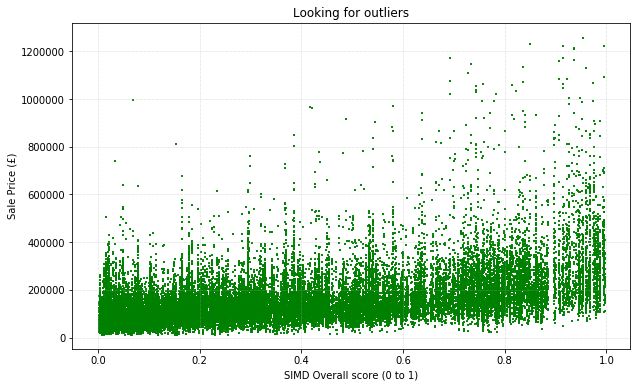

In [31]:
fig = plt.figure(figsize=(10,6))
plt.scatter(df.overall, df.price, 1, c = "green", marker='s')
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Looking for outliers")
plt.xlabel("SIMD Overall score (0 to 1)")
plt.ylabel("Sale Price (£)")
fig.savefig('outliers_final.pdf', bbox_inches="tight")

def reject_outliers(data, m=5.5):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

df.shape

In [32]:
new_price = reject_outliers(df.price)
new_price.shape

(43675,)

In [33]:
df.price = new_price
df.to_csv(path_or_buf='preremdataframe.csv', index=False)

df = df[pd.notnull(df['price'])]
print(df.shape)

(43675, 14)


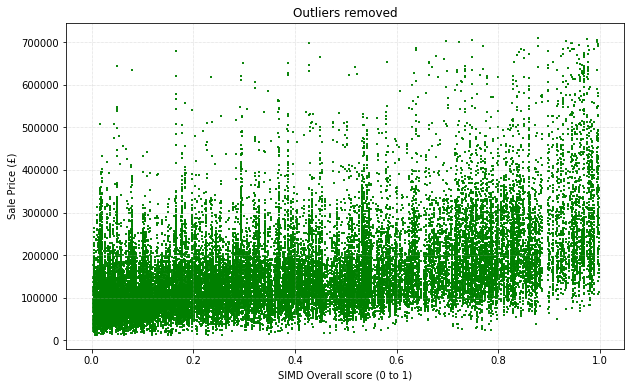

In [34]:
fig = plt.figure(figsize=(10,6))
plt.scatter(df.overall, df.price, 1, c = "green", marker='s')
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Outliers removed")
plt.xlabel("SIMD Overall score (0 to 1)")
plt.ylabel("Sale Price (£)")
fig.savefig('outliersremoved_fin.pdf', bbox_inches="tight")

In [35]:
df.head()

,price,datazone,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build,buyer_origin
76796,682931.52,S01003545,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109,2012,12,RESALE,GLASGOW
46540,627285.25,S01003257,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374,2012,12,RESALE,GLASGOW
23603,624502.94,S01003025,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012,12,RESALE,CLARKSTON
98402,550392.22,S01003242,0.289777,0.212452,0.305457,0.300384,0.479785,0.324981,0.240892,0.514681,2012,12,RESALE,GLASGOW
77244,546345.22,S01003234,0.732513,0.664566,0.603689,0.579400,0.788163,0.666103,0.743274,0.556956,2012,12,RESALE,GLASGOW


In [36]:
df.price = np.log1p(df.price)
target = df.price
df.to_csv(path_or_buf='clean_dataframe.csv', index=False)
df.head()

,price,datazone,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build,buyer_origin
76796,13.434151,S01003545,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109,2012,12,RESALE,GLASGOW
46540,13.349158,S01003257,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374,2012,12,RESALE,GLASGOW
23603,13.344713,S01003025,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012,12,RESALE,CLARKSTON
98402,13.218388,S01003242,0.289777,0.212452,0.305457,0.300384,0.479785,0.324981,0.240892,0.514681,2012,12,RESALE,GLASGOW
77244,13.211008,S01003234,0.732513,0.664566,0.603689,0.579400,0.788163,0.666103,0.743274,0.556956,2012,12,RESALE,GLASGOW


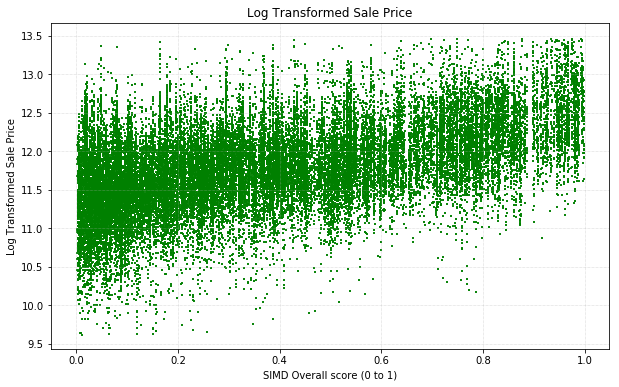

In [37]:
fig = plt.figure(figsize=(10,6))
plt.scatter(df.overall, df.price, 1, c = "green", marker='s')
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Log Transformed Sale Price")
plt.xlabel("SIMD Overall score (0 to 1)")
plt.ylabel("Log Transformed Sale Price")
fig.savefig('logged_.pdf', bbox_inches="tight")

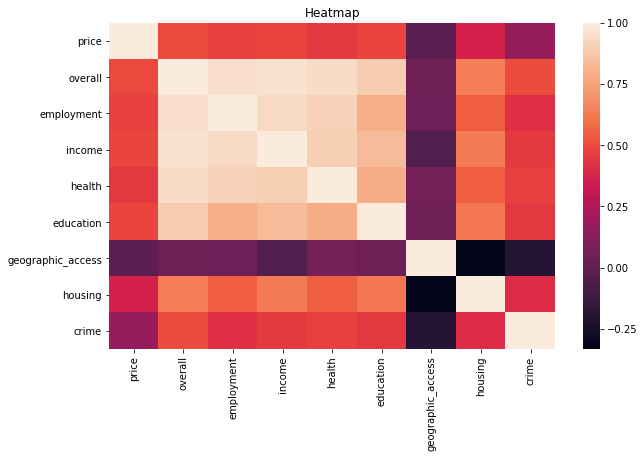

In [38]:
fig = plt.figure(figsize=(10,6))
corr = df.corr()
heatmap_p = sns.heatmap(corr)
plt.title("Heatmap")
fig.savefig('heatmap_new_small.pdf', bbox_inches="tight")

In [39]:
print("Features correlated to sale price:")
corr.sort_values(["price"], ascending = False, inplace = True)
print(corr.price)

Features correlated to sale price:
price                1.000000
overall              0.491410
education            0.482586
income               0.481448
employment           0.472597
health               0.453653
housing              0.368077
crime                0.172998
geographic_access   -0.010112
Name: price, dtype: float64


In [40]:
print("Features correlated to SIMD overall score:")
corr.sort_values(["overall"], ascending = False, inplace = True)
print(corr.overall)

Features correlated to SIMD overall score:
overall              1.000000
income               0.966735
employment           0.958273
health               0.944713
education            0.891791
housing              0.639609
crime                0.503896
price                0.491410
geographic_access    0.040248
Name: overall, dtype: float64


In [41]:
# Categorical features: Datazone, Build/Resale,  Buyer_Origin
# Also cat. feat. but removed: Street, Postcode, Date, Quarter, LHF

cat_features = df.select_dtypes(include = ['object']).columns
num_features = df.select_dtypes(exclude = ['object']).columns
num_features = num_features.drop('price')

print("Numerical features:", len(num_features))
print("Categorical features:", len(cat_features))

numerical_df = df[num_features]
categorical_df = df[cat_features]

print("Num. features NaNs:", numerical_df.isnull().values.sum())
print("Cat. features NaNs:", categorical_df.isnull().values.sum())
# These come from Buyer Origin

Numerical features: 8
Categorical features: 5
Num. features NaNs: 0
Cat. features NaNs: 2002


In [42]:
# numerical_df = numerical_df.drop(columns=['geographic_access'])
numerical_df.head()

,overall,employment,income,health,education,geographic_access,housing,crime
76796,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109
46540,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374
23603,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392
98402,0.289777,0.212452,0.305457,0.300384,0.479785,0.324981,0.240892,0.514681
77244,0.732513,0.664566,0.603689,0.579400,0.788163,0.666103,0.743274,0.556956


In [43]:
# categorical_df = categorical_df.drop(columns=['build'])
categorical_df.head()

,datazone,year,month,build,buyer_origin
76796,S01003545,2012,12,RESALE,GLASGOW
46540,S01003257,2012,12,RESALE,GLASGOW
23603,S01003025,2012,12,RESALE,CLARKSTON
98402,S01003242,2012,12,RESALE,GLASGOW
77244,S01003234,2012,12,RESALE,GLASGOW


In [44]:
categorical_df = pd.get_dummies(categorical_df)
print("Cat. features NaNs:", categorical_df.isnull().values.sum())
categorical_df.shape

Cat. features NaNs: 0


(43675, 2660)

In [45]:
skewness = numerical_df.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(skewness.shape[0], "skewed numerical features to log transform:", skewness.index.values)
idx = skewness.index
numerical_df[idx] = np.log1p(numerical_df[idx])

6 skewed numerical features to log transform: ['overall' 'health' 'education' 'geographic_access' 'housing' 'crime']


In [46]:
joined_df = pd.concat([numerical_df, categorical_df], axis = 1)
print(joined_df.shape)

(43675, 2668)


In [47]:
x_train, x_test, y_train, y_test = train_test_split(joined_df, target, test_size=0.3, random_state=0)
print("x_train : " + str(x_train.shape))
print("x_test : " + str(x_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

x_train : (30572, 2668)
x_test : (13103, 2668)
y_train : (30572,)
y_test : (13103,)


In [48]:
joined_df.head()

overall  employment    income    health  education  geographic_access  \
76796  0.681628    0.874251  0.914527  0.690222   0.653557           0.647220   
46540  0.419155    0.670869  0.396925  0.498140   0.370264           0.263605   
23603  0.566989    0.743121  0.734204  0.586932   0.639707           0.166179   
98402  0.254469    0.212452  0.305457  0.262660   0.391897           0.281398   
77244  0.549573    0.664566  0.603689  0.457045   0.581189           0.510487   

        housing     crime  datazone_S01003025  datazone_S01003026  \
76796  0.200223  0.505678                   0                   0   
46540  0.145527  0.478328                   0                   0   
23603  0.494115  0.524960                   1                   0   
98402  0.215830  0.415205                   0                   0   
77244  0.555765  0.442733                   0                   0   

       datazone_S01003027  datazone_S01003028  datazone_S01003029  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003030  datazone_S01003032  datazone_S01003033  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003034  datazone_S01003035  datazone_S01003036  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003037  datazone_S01003038  datazone_S01003039  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003040  datazone_S01003041  datazone_S01003042  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003043  datazone_S01003044  datazone_S01003045  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003046  datazone_S01003047  datazone_S01003048  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003049  datazone_S01003050  datazone_S01003051  \
76796                   0                   0                   0   
46540                   0                   0                  

In [49]:
# # Standardize numerical features
# scaler = StandardScaler()
# # x_train.loc[:, num_features] = scaler.fit_transform(x_train.loc[:, num_features])
# # x_test.loc[:, num_features] = scaler.transform(x_test.loc[:, num_features])
# joined_df.loc[:, num_features] = scaler.fit_transform(joined_df.loc[:, num_features])

In [50]:
joined_df.head()

overall  employment    income    health  education  geographic_access  \
76796  0.681628    0.874251  0.914527  0.690222   0.653557           0.647220   
46540  0.419155    0.670869  0.396925  0.498140   0.370264           0.263605   
23603  0.566989    0.743121  0.734204  0.586932   0.639707           0.166179   
98402  0.254469    0.212452  0.305457  0.262660   0.391897           0.281398   
77244  0.549573    0.664566  0.603689  0.457045   0.581189           0.510487   

        housing     crime  datazone_S01003025  datazone_S01003026  \
76796  0.200223  0.505678                   0                   0   
46540  0.145527  0.478328                   0                   0   
23603  0.494115  0.524960                   1                   0   
98402  0.215830  0.415205                   0                   0   
77244  0.555765  0.442733                   0                   0   

       datazone_S01003027  datazone_S01003028  datazone_S01003029  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003030  datazone_S01003032  datazone_S01003033  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003034  datazone_S01003035  datazone_S01003036  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003037  datazone_S01003038  datazone_S01003039  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003040  datazone_S01003041  datazone_S01003042  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003043  datazone_S01003044  datazone_S01003045  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003046  datazone_S01003047  datazone_S01003048  \
76796                   0                   0                   0   
46540                   0                   0                   0   
23603                   0                   0                   0   
98402                   0                   0                   0   
77244                   0                   0                   0   

       datazone_S01003049  datazone_S01003050  datazone_S01003051  \
76796                   0                   0                   0   
46540                   0                   0                  

In [51]:
# # Define error measure for official scoring : RMSE
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# def rmse_cv_train(model):
#     rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring=mse_scorer, cv=10))
#     return(rmse)

# def rmse_cv_test(model):
#     rmse = np.sqrt(-cross_val_score(model, x_test, y_test, scoring=mse_scorer, cv=10))
#     return(rmse)

# def rmse_cv_df(model):
#     rmse = np.sqrt(-cross_val_score(model, joined_df, target, scoring=mse_scorer, cv=10))
#     return(rmse)

In [52]:
# Linear Regression
lr_model = LinearRegression()
# lr_model.fit(x_train, y_train)
lr_model.fit(joined_df, target)

# Look at predictions on training and validation set
# print("RMSE on Training set :", rmse_cv_train(lr_model).mean())
# print("RMSE on Test set :", rmse_cv_test(lr_model).mean())
# print("RMSE on Training set :", rmse_cv_df(lr_model).mean())

# y_train_pred = lr_model.predict(x_train)
# y_test_pred = lr_model.predict(x_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
y_train_pred = lr_model.predict(joined_df)
y_test_pred = lr_model.predict(x_test)

print("R2 Score Test:", lr_model.score(x_test, y_test).mean())
print("R2 Score Train:", lr_model.score(x_train, y_train).mean())
print("MSE Test:", mean_squared_error(y_test, y_test_pred).mean())
print("RMSE Test:", np.sqrt(mean_squared_error(y_test, y_test_pred).mean()))
print("MAE:", mean_absolute_error(y_test, y_test_pred).mean())

R2 Score Test: 0.6457490658912561
R2 Score Train: 0.6502428632249087
MSE Test: 0.10165649707087789
RMSE Test: 0.318836160231047
MAE: 0.23520769232161237


In [ ]:
complete_df = pd.concat([x_test, y_test], axis=1)
complete_df['predicted_price'] = y_test_pred
complete_df = complete_df[['price','predicted_price','overall','employment','income','health','education',
         'geographic_access','housing','crime']]
complete_df.to_csv(path_or_buf='complete_df.csv', index=False)
complete_df.head()

In [ ]:
# Plot pred vs price
fig = plt.figure(figsize=(10,6))
plt.scatter(complete_df.predicted_price, complete_df.price, 2, c = "green", marker = "s")
plt.title("Linear Regression - Predictions against actual prices")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.plot([10.7, 12.8], [10.6, 13.0], c = "red")
fig.savefig('linear_regression_pred_vs_price.pdf', bbox_inches="tight")

In [ ]:
feat_coff = pd.DataFrame(list(zip(joined_df.columns, lr_model.coef_)), columns = ['Features', 'Coefficients'])
feat_coff.Coefficients[[6]] = -0.0240209118491
feat_coff = feat_coff.sort_values(by='Coefficients', ascending=True)
feat_coff = feat_coff[feat_coff.Features.isin(num_features)]
feat_coff = feat_coff.set_index('Features')
feat_coff.to_csv(path_or_buf='coeff.csv', index=False)
feat_coff

In [ ]:
coeff_plot = feat_coff.plot(kind='barh', figsize=(10,6), color='green')
fig = coeff_plot.get_figure()
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Coefficients in Linear Regression Model")
fig.savefig('linear_regression_coe2.pdf', bbox_inches="tight")

In [ ]:
# Plot residuals
fig = plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train_pred - y_train, 2, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, 2, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear Regression - Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc = "upper right")
plt.hlines(y = 0, xmin = 10.2, xmax = 13.3, color = "red")
fig.savefig('linear_regression_residuals2.pdf', bbox_inches="tight")

In [ ]:
# Plot predictions
fig = plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train, 2, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, 2,c = "orange", marker = "s", label = "Validation data")
plt.title("Linear Regression - Predictions")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.2, 13.2], [10.2, 13.2], c = "red")
fig.savefig('linear_regression_predictions2.pdf', bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
x = ['Ward - Euclidean',
     'Average - Euclidean',
     'Average - Manhattan',
     'Complete - Euclidean',
     'Complete - Manhattan']

y = [0.4585054410838514, 0.411178230729844, 0.38054918724238823,
     0.41757725658002337, 0.3939523655501585]
z = [0.8871998368269876, 0.8714664029864378, 0.8705347573408821,
     0.8804779252681949, 0.8787845930927598]
k = [0.8590934815745167, 0.8570671637777433, 0.8569801407406784,
     0.8581845355703639, 0.8580289478960755]

_X = np.arange(len(x))
plt.yticks(np.arange(0, 1, 0.1))

plt.bar(_X - 0.1, y, 0.1, color='r')
plt.bar(_X, z, 0.1, color='g')
plt.bar(_X + 0.1, k, 0.1, color='b')
plt.xticks(_X, x) # set labels manually
plt.grid(linestyle=':', linewidth=0.5, axis='y')
ax.legend(('Silhouette Score', 'Homogeneity Score',
           'Completeness Score'), bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
fig.savefig('hierarchical_compared2.pdf', bbox_inches="tight")

In [ ]:
# # Move target column as first column here
# # target = df.values[:, 0]
# # attributes = df.values[:, 1:]
# attributes = joined

# # scaled = scale(attributes)
# scaler = StandardScaler()
# scaler.fit(joined)
# scaled_attributes = scaler.transform(attributes)

In [ ]:
# scaler.fit(df.values)
# scaled_full = scaler.transform(df.values)

In [ ]:
# pca = PCA(n_components=12)
# pca.fit(scaled_attributes)

# pca = PCA(n_components=8)
# X_pca = pca.fit_transform(joined_df)

# lr_model.fit(X_pca,target)

In [ ]:
# var_ratio = pca.explained_variance_ratio_.cumsum()
# print(var_ratio)
# fig = plt.figure(figsize=(10,6))
# plt.title('PCA number of Components against Variance Ratio')
# plt.xlabel('Number of Components')
# plt.xticks(np.arange(0, 13, step=1))
# plt.ylabel('Variance Ratio')
# plt.plot(var_ratio, '--bo')
# fig.savefig('pca_components_variance.pdf', bbox_inches="tight")

In [ ]:
# n_samples, n_features = scaled_attributes.shape
# n_digits = len(np.unique(target))
# # encoded_target = LabelEncoder().fit_transform(target)
# model = cluster.AgglomerativeClustering(n_clusters=n_digits, linkage="ward", affinity="euclidean")
# model.fit(scaled_attributes)

# # print(encoded_outcome)
# print("length:", n_digits)
# print("n samples:", n_samples, "n features:", n_features)

# # print(model.labels_)
# print(metrics.silhouette_score(scaled_attributes, model.labels_))
# print(metrics.completeness_score(target, model.labels_))
# print(metrics.homogeneity_score(target, model.labels_))

In [ ]:
n_samples, n_features = joined_df.shape
n_digits = len(np.unique(target))
# encoded_target = LabelEncoder().fit_transform(target)
model = cluster.AgglomerativeClustering(n_clusters=n_digits, linkage="ward", affinity="euclidean")
model.fit(joined_df)

# print(encoded_outcome)
print("length:", n_digits)
print("n samples:", n_samples, "n features:", n_features)

# print(model.labels_)
print(metrics.silhouette_score(joined_df, model.labels_))
print(metrics.completeness_score(target, model.labels_))
print(metrics.homogeneity_score(target, model.labels_))

In [ ]:
Z = linkage(scaled_attributes, 'ward')
# fig = plt.figure(figsize=(20,70))
# plt.title('Hierarchical Clustering Dendrogram (Ward)')
# plt.xlabel('Distance')
# plt.ylabel('Sample Index')
# dendrogram(
#     Z,
#     p=100,
#     truncate_mode='lastp',
#     orientation='right',
# #     leaf_rotation=90.,
#     leaf_font_size=8.
#     )
# fig.savefig('dendro_ward_slarg.pdf', bbox_inches="tight")

In [ ]:
# # df = df.drop(columns=['price'])
# X = df.T.values #Transpose values 
# Y = pdist(X)
# z_matrix = linkage(Y)
# fig = plt.figure(figsize=(15,20))
# dendrogram(z_matrix, labels=target_cols)

In [ ]:
c, coph_dists = cophenet(Z, pdist(scaled_attributes))
c

In [ ]:
print(len(scaled_attributes))
print(10299 - len(scaled_attributes))
print(list(map('{:.0f}'.format,Z[1080])))
print(list(map('{:.0f}'.format,Z[408])))
np.savetxt("from_price_to_dz.csv", Z, delimiter=",")

In [ ]:
df.iloc[[60211 - len(target)]]

# print(df.values[6740])
# print(vg_sales.as_matrix()[3568])
# print(df.values[1876])
# print(vg_sales.as_matrix()[3568])

In [ ]:
df.iloc[[60213 - len(target)]]

In [ ]:
print(df.info())

In [ ]:
fig = plt.figure(figsize=(50,50))
plt.title('this is test')
plt.xlabel('x test')
plt.ylabel('y test')
df.overall.plot(kind='box', subplots=True)
fig.savefig('test.pdf', bbox_inches="tight")

In [ ]:
df.price.plot(kind='box')
create_pdf_fig('price_box')